<a href="https://colab.research.google.com/github/manyasha-n-m/OT-tutorials/blob/main/Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hands-on Tutorials on Computational Optimal Transport
### Instructor: Nataliia Monina
-----

### 1. Regularization of Optimal Tranpost
In this notebook, we'll:
1. Utilize duality theory for entropy- (and general convex-) regularized OT and implementation of Sinkhorn from the duality point of view
2. Explore the role of initialization (for our Sinkhorn) of the problem, any difference in solutions?
3. Implement algorighms for OT approximation with a 'chosen' convex function $\psi$ via gradient ascent and imitation of Sinkhorn
4. Compare solutions (optimal plans P) achieved by different regularizations


**Feel free to go back to `Tutorial 1` for some code snippets when you want to compare**

Let's first set up some data for our experiments

In [1]:
# !pip install POT --quiet
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
%matplotlib inline

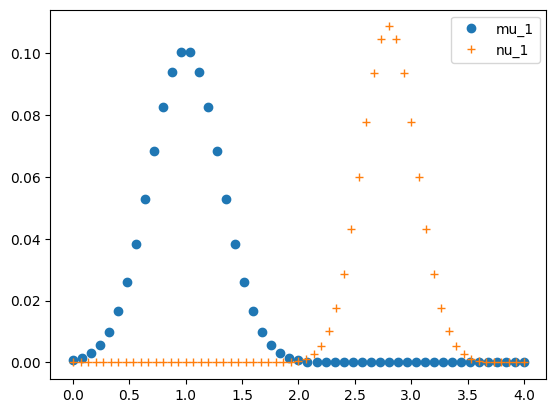

In [107]:
X_1 = np.linspace(0,4, 51)
Y_1 = np.linspace(0,4, 61)

def discrete_gaussian(mean, variance, interval):
    f = np.exp(-(interval-mean)**2/(2*variance)) / np.sqrt(2*np.pi*variance)
    return f/f.sum()

mu_1 = discrete_gaussian(1, 0.1, X_1)
nu_1 = discrete_gaussian(2.8, 0.06, Y_1)

'''Test measures'''

plt.figure(2)
plt.plot(X_1, mu_1, 'o', label="mu_1")
plt.plot(Y_1, nu_1, '+', label="nu_1")
plt.legend(loc=0)

'''Cost: Distance squared '''

C_1 = (X_1[:, None] - Y_1[None, :]) ** 2
# C_1 /= C_1.sum() 

In [108]:
# helpful function to plot and analyze our solutions
def analyze_solutions(mu, nu, P_computed, P_for_compare, epsilon, C):
    """
    Parameters
    ----------
    mu: np.ndarray
        Actual measure mu
    nu: np.ndarray
        Actual measure nu
    P_computed: np.ndarray
        Computed plan P with the chosen method
    P_for_compare: np.ndarray
        Reference plan P to compare with (e.g., output of ot.emd)

    Returns
    -------
    plt.figure
        Plot of comparisons for our computed solution
    """

    plt.figure()
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    # error of marginals
    # mu vs. output
    ax[0].plot(mu)
    ax[0].plot(np.sum(P_computed, axis=1), '--')
    ax[0].set_title('mu vs P_computed_mu')
    # nu vs. output
    ax[1].plot(nu)
    ax[1].plot(np.sum(P_computed, axis=0), '--')
    ax[1].set_title('nu vs P_computed_nu')

    # comparison of plans
    ax[2].imshow(P_computed)
    ax[2].set_title(f"P_computed (eps={epsilon})")
    ax[3].imshow(P_for_compare)
    ax[3].set_title(f"P_for_compare")

    print("Cost of P_computed:", np.einsum('ij,ij', C, P_computed))
    print("Cost of P_for_compare:", np.einsum('ij,ij', C, P_for_compare))
    return ax


## Sinkhorn implementation through duality theory



Recall the Primal-Dual entropy regularized problems.

### The regularized Primal problem

Fix $\varepsilon>0$. We are looking for a solution of

$P^{\varepsilon}\in argmin \{F^{\varepsilon}_C(P) := \sum\limits_{i=0}^{n-1}\sum\limits_{j=0}^{m-1}C_{ij}P_{ij} +\varepsilon \sum\limits_{i=0}^{n-1}\sum\limits_{j=0}^{m-1} P_{ij}(\log P_{ij}-1)\,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\}$


### The regularized Dual problem

Consider a function $D^{\varepsilon}_{C}:\mathbb{R}^n \times \mathbb{R}^m \to \mathbb{R}:$

$D^{\varepsilon}_{C}(u,v) = \sum_{i=0}^{n-1} u_i \mu_i + \sum_{j=n}^{m-1} v_j \nu_j - \varepsilon \sum_{i=0}^{n-1}\sum_{j=0}^{m-1} e^{\frac{u_i+v_j - C_{ij}}{\varepsilon}}$

#### Facts (Optimization Theory):
1. It turns out that

$$\min \{F^{\varepsilon}_C(P) \,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\} = \max \{ D^{\varepsilon}_C(u,v) \,:\, u\in \mathbb{R}^n,~ v\in \mathbb{R}^m\}.$$

2. There exists a unique minimizer $P^{\varepsilon}$ of $F^{\varepsilon}_C$ and it has a shape
$$
P^{\varepsilon}_{ij}  = e^{\frac{u^{\varepsilon}_i+v^{\varepsilon}_j - C_{ij}}{\varepsilon}},
$$
where $u^{\varepsilon}_i$ and $v^{\varepsilon}_j$ are (any) maximizers of the Dual problem $D^{\varepsilon}_C$.


## Sinkhorn algorithm
*Idea:* Do the alternate maximization of the functional $D^\varepsilon_C$.

`Start`: Initialize $(u^{(0)}, v^{(0)})$ with some values, e.g. $(0,0)$.

`Iterations`: for $l=1, 2, ...$ do
1. Compute $u^{(l)} = argmax \{ D^{\varepsilon}_C (u, v^{(l-1)}) \,:\, u \in \mathbb{R^n}\}$.
2. Compute $v^{(l)} = argmax \{ D^{\varepsilon}_C (u^{(l)}, v) \,:\, v \in \mathbb{R}^m\}$.
3. (Optional) Compute $P^{(l)} = e^{\frac{u^{(l)}\oplus v^{(l)} - C}{\varepsilon}}$

### (!) There are explicit formula for those $argmax D^\varepsilon_C(\cdot, V)$ and $argmax D^\varepsilon_C(U, \cdot)$ for entropic regularizaition -- compute it!





### Exercise:
Fill in the gaps in this Sinkhorn implementation

Idea:
1. Find what are the formulas $\frac{\partial D_C^\varepsilon}{\partial u_i}$ and $\frac{\partial D_C^\varepsilon}{\partial v_j}$
2. For fixed $v$, what is the condition for $u= argmax D_C^\varepsilon(⋅, v)$ ? What about $u$?

In [117]:
def sinkhorn(mu, nu, C, v_init, eps=0.01, max_iter=100, tol=1e-6):
    # Initialize dual variables
    v = v_init

    for it in range(max_iter):
        # Update rules (TODO):

        '''modify this part'''
        u = eps * np.log(mu) - eps * np.log(np.exp((v[None, :] - C) / eps).sum(axis=1))
        v = eps * np.log(nu) - eps * np.log(np.exp((u[:, None] - C) / eps).sum(axis=0))
        '''answer is at the bottom of this tutorial, but try yourself first!!!'''

        P = np.exp((u[:, None]+ v[None, :] - C) / eps)
        # Convergence check
        if np.linalg.norm(mu - np.sum(P, axis=1), 1) < tol:
            print('n_iters:', it)
            break

    return P, u, v


In [118]:
'''Test your Sinkhorn and compare with POT library output'''

# epsilon = 1e-6 
epsilon = 0.01
P_test, u_ep, v_ep = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)

Cost of P_computed: 3.236366503830734
Cost of P_for_compare: 3.247895419559598


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.01)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

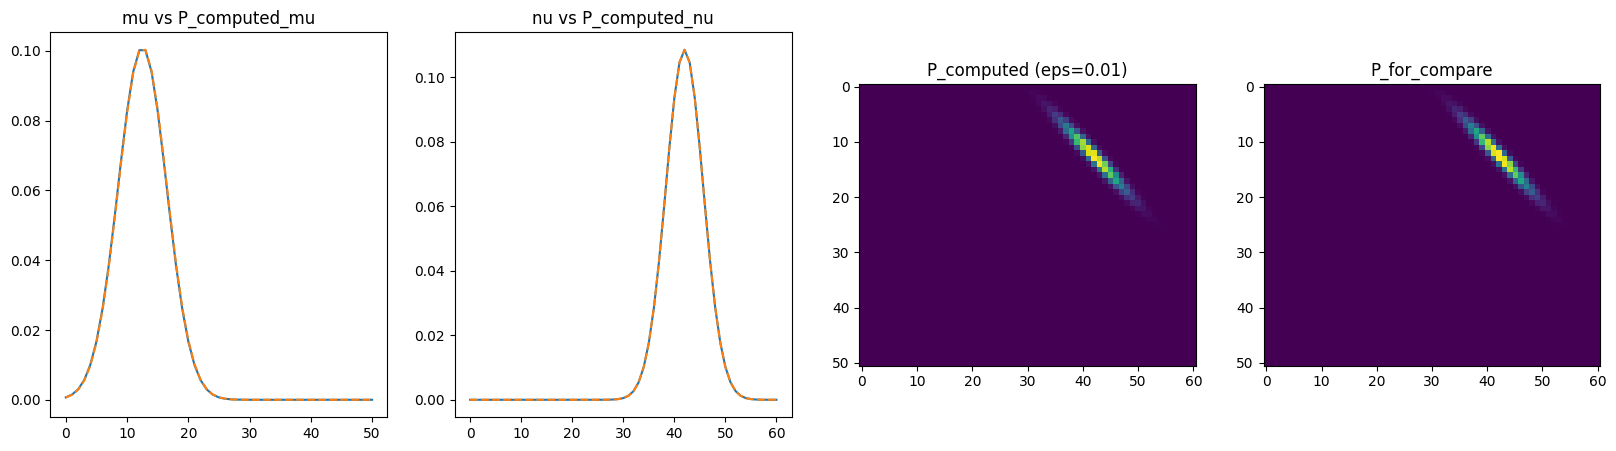

In [119]:
# to compare with
P_pot_sink = ot.sinkhorn(mu_1, nu_1, C_1, epsilon)

analyze_solutions(mu_1, nu_1, P_test, P_pot_sink, epsilon, C_1)

### Exercises:
- For particular examples, try different initialization of $(u,v)$ in our implementation of Sinkhorn and compare output solutions.
    * E.g. take initialization `(u1, v1)` and compute output of Sinkhorn `(u1_out, v1_out)`, then try a different initialization `(u2, v2)` and compute output of Sinkhorn `(u2_out, v2_out)`. Then compute differences: `lambda_u = u1_out-u2_out` and `lambda_v = v2_out-v1_out` then, plot them. What do you see?

- Play around with epsilon, different marginals, costs, our $\mathbb R^1$ or $\mathbb R^2$ examples




Cost of P_computed: 3.237045603838789
Cost of P_for_compare: 3.236366503830734


/var/folders/15/jlg3w5bs0397x9n4mllqps3h0000gn/T/ipykernel_89886/2837076518.py:9: RuntimeWarning: overflow encountered in exp
  u = eps * np.log(mu) - eps * np.log(np.exp((v[None, :] - C) / eps).sum(axis=1))


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.01)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

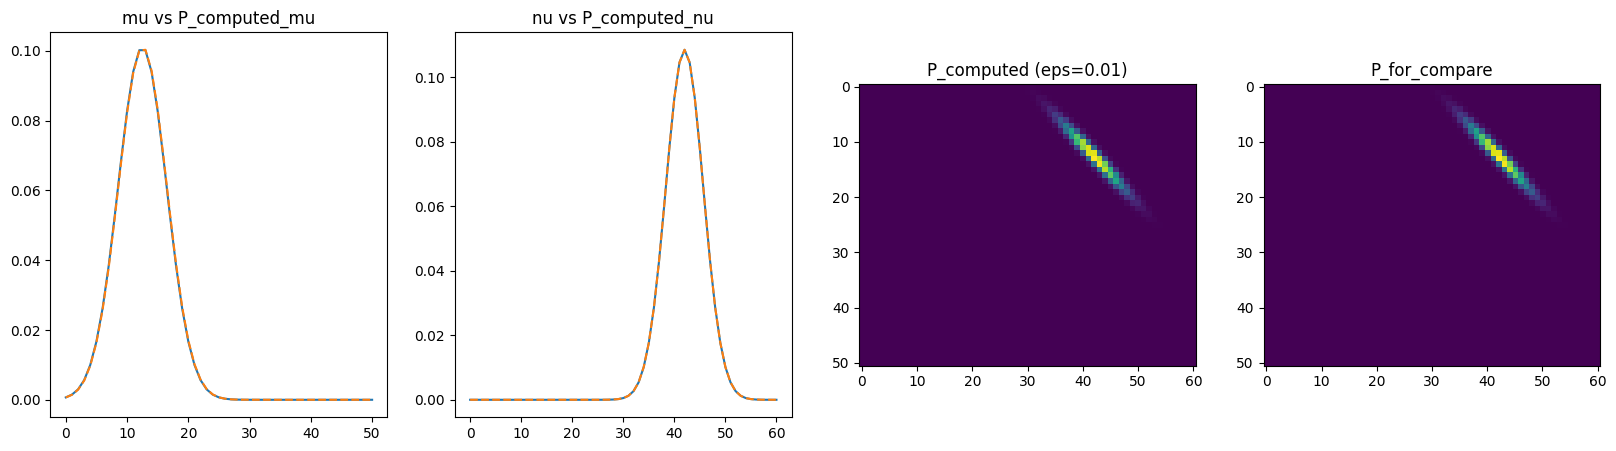

In [120]:
# experiment here with different regularization

v_init = np.random.random(len(nu_1)) + 1  # for example
P_test_ep_rand, u_ep_rand, v_ep_rand = sinkhorn(mu_1, nu_1, C_1, v_init, eps=epsilon)


analyze_solutions(mu_1, nu_1, P_test_ep_rand, P_test, epsilon, C_1)

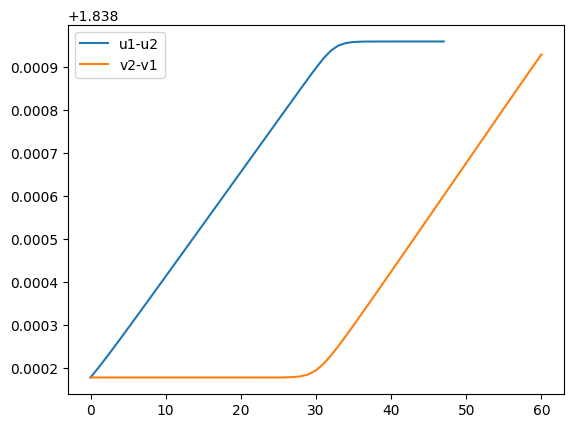

In [121]:
# compare solutions with different initialization
plt.figure()
plt.plot(u_ep-u_ep_rand)
plt.plot(v_ep_rand-v_ep)
plt.legend(['u1-u2', 'v2-v1'])

# you can modify this part (limits of y-axis on your plot)
# ================
# plt.ylim(-10, 10)
# ================

In [122]:
'''Free space for other experiments'''


'Free space for other experiments'

## General convex regularization and algorithm
### Convex regularized Primal problem

Fix $\varepsilon>0$ and $\phi:[0,\infty)\to\mathbb R$ be a superlinear convex function bounded from below. We are looking for a solution of

$P^{\varepsilon}\in argmin \{F^{\varepsilon}_C(P) := \sum\limits_{i=0}^{n-1}\sum\limits_{j=0}^{m-1}C_{ij}P_{ij} +\varepsilon \sum\limits_{i=0}^{n-1}\sum\limits_{j=0}^{m-1} \phi(P_{ij})\,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\}$


### Convex regularized Dual problem

Let $\varepsilon>0$ and let $\psi:\mathbb R\to \mathbb R$ be a superlinear convex function bounded from below. Consider a function $D^{\varepsilon}_{C}:\mathbb{R}^n \times \mathbb{R}^m \to \mathbb{R}:$

$D^{\varepsilon}_{C}(u,v) = \sum_{i=0}^{n-1} u_i \mu_i + \sum_{j=n}^{m-1} v_j \nu_j - \varepsilon \sum_{i=0}^{n-1}\sum_{j=0}^{m-1} \psi({\frac{u_i+v_j - C_{ij}}{\varepsilon}})$

### **Facts (Optimization Theory)**:
1. It turns out that if $\psi(y) = \sup\limits_{x\geq 0}\{xy- \phi(x)\}$

$$\min \{F^{\varepsilon}_C(P) \,:\, P_{ij}\geq 0, \, \sum\limits_{i=0}^{n-1} P_{ij} = \nu_{j}, \, \sum\limits_{j=0}^{m-1} P_{ij} = \mu_i\} = \max \{ D^{\varepsilon}_C(u,v) \,:\, u\in \mathbb{R}^n,~ v\in \mathbb{R}^m\}.$$

2. If  $\frac{d \psi}{d y}$ exists, then there exists a unique minimizer $P^{\varepsilon}$ of $F^{\varepsilon}_C$ and it has a shape
$$
P^{\varepsilon}_{ij}  = \psi'({\frac{u^{\varepsilon}_i+v^{\varepsilon}_j - C_{ij}}{\varepsilon}}),
$$
where $u^{\varepsilon}_i$ and $v^{\varepsilon}_j$ are (any) maximizers of the Dual problem $D^{\varepsilon}_C$.

---
For this tutorial, let's consider the following convex functions for regularization

$\psi_0(y) = \exp(y)$

$\psi_1(y) = \frac12 (y_+)^2 = \begin{cases}\frac12 y^2, & y\geq 0 \\ 0, & o.w.\end{cases}$

$\psi_2(y) = \log(1+ \exp(y))$



In [123]:
psi_0 = np.exp

psi_1 = lambda y: (y ** 2) / 2 * (y > 0)

psi_2 = lambda y: np.log(1 + np.exp(y))

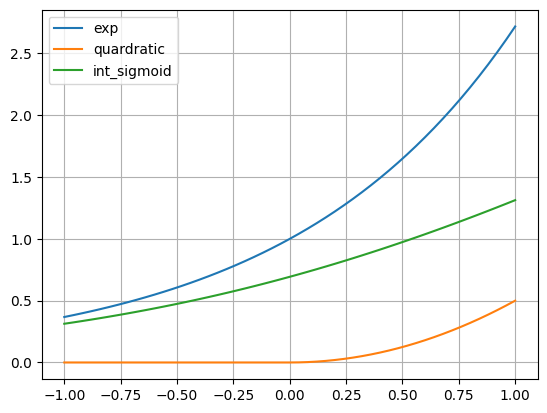

In [124]:
# visualisation of test psi functions

interval = np.linspace(-1, 1, 51)
plt.plot(interval, psi_0(interval))
plt.plot(interval, psi_1(interval))
plt.plot(interval, psi_2(interval))
plt.legend(['exp', 'quardratic', 'int_sigmoid'])
plt.grid()



## Algorithm (with simple gradient ascent)
*Idea:* Use gradient methods, e.g., gradient ascent to find solutions.

`Start`: Initialize $(u^{(0)}, v^{(0)})$ with some values, e.g. $(0,0)$ and choose a learning rate $\alpha$.

`Iterations`: for $l=1, 2, ...$ do (for example)
1. Compute $u^{(l)} = u^{(l-1)} + \alpha  \frac{\partial D^{\varepsilon}_C}{\partial u} (u^{(l-1)}, v^{(l-1)})$.
2. Compute $v^{(l)} = v^{(l-1)}+ \alpha  \frac{\partial D^{\varepsilon}_C}{\partial v} (u^{(l)}, v^{(l-1)})$.
3. (Optional) Compute $P^{(l)} = \psi'({\frac{u^{(l)}\oplus v^{(l)} - C}{\varepsilon}})$


#### **Side comment:** one can, of course, also experiment with already implemented gradient optimizers (e.g. Adam) directly by specifying the variable $(u,v)=(u_1,...,u_N, v_1,..., v_M)$ and the gradient $\nabla D^{\varepsilon}_C = (\frac{\partial D^{\varepsilon}_C}{\partial u_1},...,\frac{\partial D^{\varepsilon}_C}{\partial u_N}, \frac{\partial D^{\varepsilon}_C}{\partial v_1}, ..., \frac{\partial D^{\varepsilon}_C}{\partial v_M})$.

----
 (!) Notice that when $\psi=exp$, then we can directly solve $(\frac{D^{\varepsilon}_C}{\partial u}, \frac{D^{\varepsilon}_C}{\partial v})=0$, so there is no need to do a gradient step - we can directly jump to the best candidate for a given second variable fixed.


## Exercise:
- Compute all necessary derivatives (pen and paper)
- Fill in the gaps in the derivarives and the algorithm
- Play with parameters `alpha`, `max_iter` and so on

In [125]:
'''Answers are at the bottom of this tutorial, but try yourself first!!!'''

psi_0_prime = lambda y: np.exp(y) 
psi_1_prime = lambda y: y * (y > 0) 
psi_2_prime = lambda y: 1 / (1 + np.exp(-y))

def dD_du(u, v, mu, C, psi_prime, eps):
    """returns: d D_C / d u (u, v) for chosen psi"""

    return mu - psi_prime((u[:, None] + v[None, :] - C) / eps).sum(axis=1)


def dD_dv(u, v, nu, C, psi_prime, eps):
    """returns: d D_C / d v (u, v) for chosen psi"""

    return nu - psi_prime((u[:, None] + v[None, :] - C) / eps).sum(axis=0)


def grad_ascent_D(mu, nu, C, u_init, v_init, eps=0.01, psi_prime=np.exp, alpha=0.05, max_iter=50000, tol=1e-6):
    # Initialize dual variables
    u = u_init
    v = v_init

    for it in range(max_iter):
        if (it+1) % 10000 == 0:
            print('n_iters:', it+1)
        # Update rules (TODO):

        '''modify this part'''
        u = u + alpha * dD_du(u, v, mu, C, psi_prime, eps) 
        v = v + alpha * dD_dv(u, v, nu, C, psi_prime, eps) 

        P = psi_prime((u[:, None] + v[None, :] - C) / eps)
        '''answer is at the bottom of this tutorial, but try yourself first!!!'''

        # Convergence check
        if np.linalg.norm(mu - np.sum(P, axis=1), 1) < tol:
            print('n_iters:', it+1)
            break

    return P, u, v


Test on psi_0

In [126]:
epsilon = 0.01
u_0 = np.zeros_like(mu_1)
v_0 = np.zeros_like(nu_1)
P_0, u_0, v_0 = grad_ascent_D(mu_1, nu_1, C_1, u_0, v_0, epsilon, psi_0_prime, alpha=0.1)

n_iters: 10000
n_iters: 20000
n_iters: 30000
n_iters: 40000
n_iters: 50000


Cost of P_computed: 3.228406776037454
Cost of P_for_compare: 3.236366503830734


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.01)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

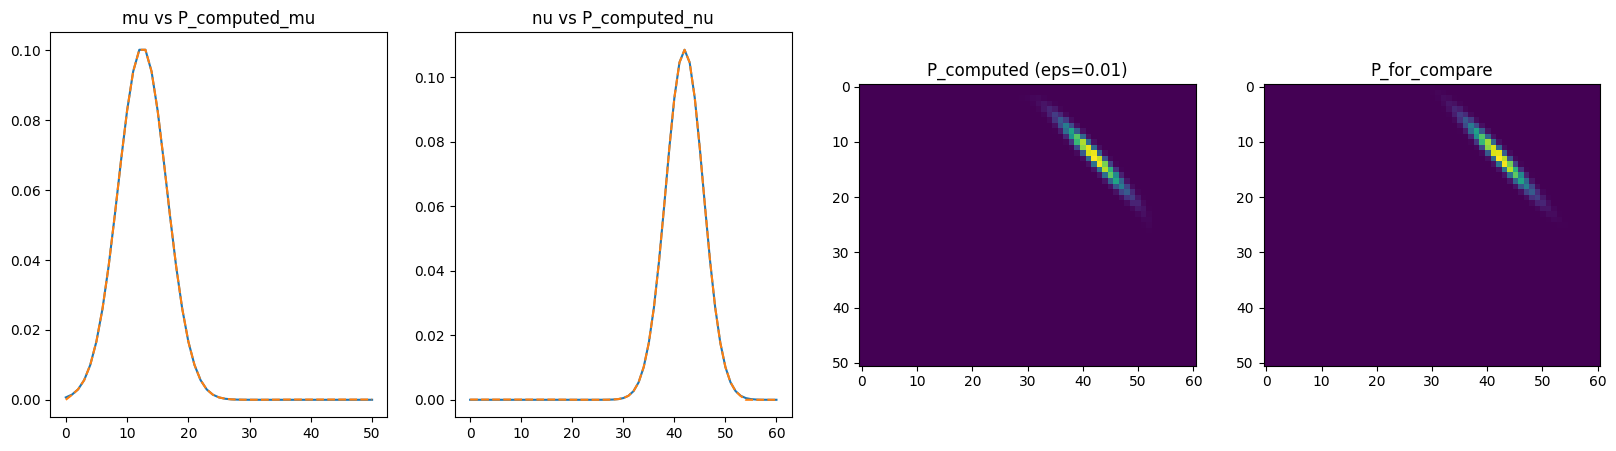

In [127]:
# to compare with our sinkhorn, to see n_iters
P_test, _, _ = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)
analyze_solutions(mu_1, nu_1, P_0, P_test, epsilon, C_1)

test on psi_1

In [134]:
epsilon = 0.1
u_0 = np.zeros_like(mu_1)
v_0 = np.zeros_like(nu_1)
P_1, u_1, v_1 = grad_ascent_D(mu_1, nu_1, C_1, u_0, v_0, epsilon, psi_1_prime, max_iter=90000, alpha=0.03)

n_iters: 10000
n_iters: 20000
n_iters: 30000
n_iters: 40000
n_iters: 50000
n_iters: 60000
n_iters: 70000
n_iters: 80000
n_iters: 90000


n_iters: 24
Cost of P_computed: 3.207151614008959
Cost of P_for_compare: 3.2850791721958967


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

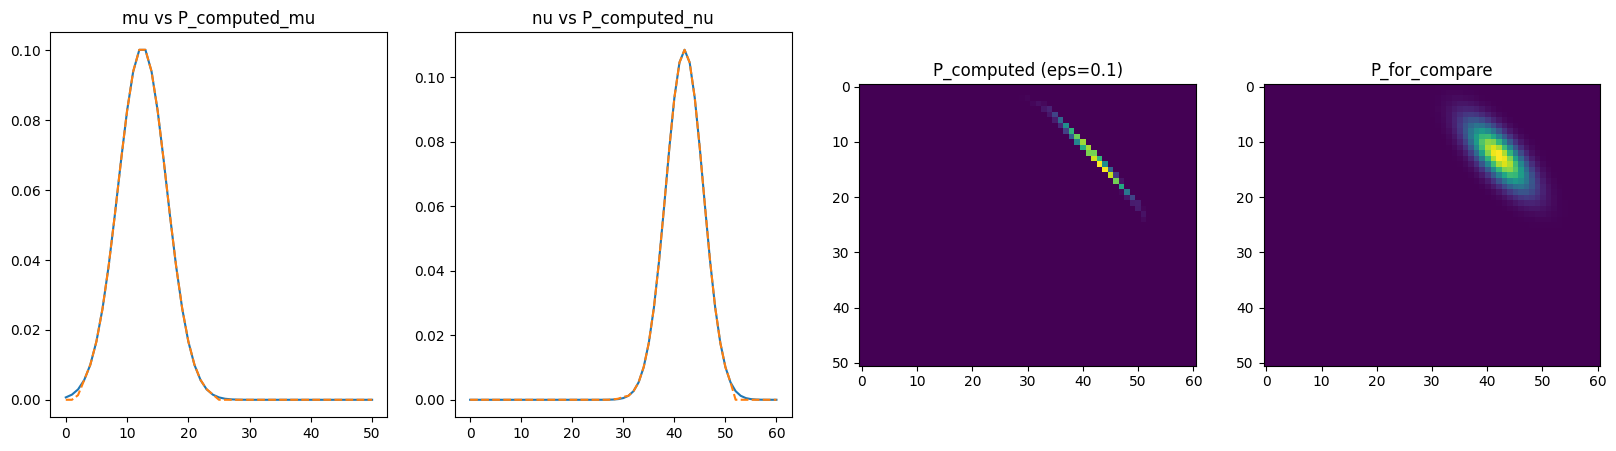

In [135]:
# to compare with
P_test, _, _ = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)

analyze_solutions(mu_1, nu_1, P_1, P_test, epsilon, C_1)

test on psi_2

In [130]:
epsilon = 0.01
u_0 = np.zeros_like(mu_1)
v_0 = np.zeros_like(nu_1)
P_2, u_2, v_2 = grad_ascent_D(mu_1, nu_1, C_1, u_0, v_0, epsilon, psi_2_prime)

/var/folders/15/jlg3w5bs0397x9n4mllqps3h0000gn/T/ipykernel_89886/747479665.py:5: RuntimeWarning: overflow encountered in exp
  psi_2_prime = lambda y: 1 / (1 + np.exp(-y))


n_iters: 10000
n_iters: 20000
n_iters: 30000
n_iters: 40000
n_iters: 50000


Cost of P_computed: 3.2040198919269143
Cost of P_for_compare: 3.236366503830734


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.01)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

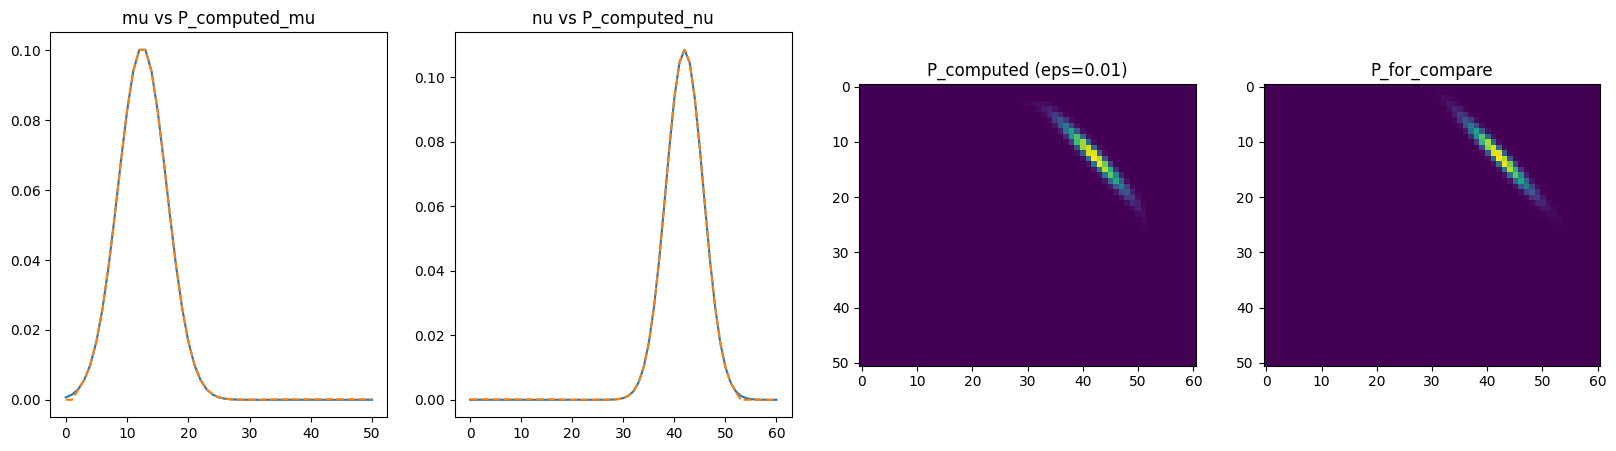

In [131]:
# to compare with
P_test, _, _ = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)

analyze_solutions(mu_1, nu_1, P_2, P_test, epsilon, C_1)

## One can also try imitating a Sinkhorn-type algorithm

*Idea:* Do the alternate maximization of the functional $D^\varepsilon_C$.

`Start`: Initialize $(u^{(0)}, v^{(0)})$ with some values, e.g. $(0,0)$.

`Iterations`: for $l=1, 2, ...$ do:
1. Compute $u^{(l)} \approx argmax \{ D^{\varepsilon}_C (u, v^{(l-1)}) \,:\, u \in \mathbb{R^n}\}$:
    * Run several iterations of, e.g., a gradient step. Set $u^{(l, 0)} = u^{(l-1)}$

    * `Internal iterations:` for $k=1,2,...N_l$ do:

        $u^{(l,k)} = u^{(l, k-1)} + \alpha  \frac{D^{\varepsilon}_C}{\partial u} (u^{(l, k-1)}, v^{(l-1)})$
    * Set $u^{(l)} = u^{(l,N_l)}$

2. Compute $v^{(l)} \approx argmax \{ D^{\varepsilon}_C (u^{(l)}, v) \,:\, v \in \mathbb{R}^m\}$ (by similar principle as for $u^{(l)})$.
3. (Optional) Compute $P^{(l)} = \psi'(\frac{ u^{(l)}\oplus v^{(l)} - C}{\varepsilon})$

### Exercises
- Fill in the gaps
- Play with initializations, learning rate `alpha`, `max_iter`, etc.

In [140]:
def maximize_D_in_u(u_start, v, mu, C, eps, psi_prime, alpha=0.05, max_iter=50000, tol=1e-6):
    u = u_start
    for it in range(max_iter):
        # Update rules (TODO):
        u_prev = np.copy(u)

        '''modify this part'''
        u = u + alpha * dD_du(u, v, mu, C, psi_prime, eps) 
        '''answer is at the bottom of this tutorial, but try yourself first!!!'''
        # Convergence check
        if np.linalg.norm(u - u_prev, 1) < tol:
            break
    return u

def maximize_D_in_v(u, v_start, nu, C, eps, psi_prime, alpha=0.05, max_iter=50000, tol=1e-6):
    v = v_start
    for it in range(max_iter):
        # Update rules (TODO):
        v_prev = np.copy(v)

        '''modify this part'''
        v = v + alpha * dD_dv(u, v, nu, C, psi_prime, eps) 
        '''answer is at the bottom of this tutorial, but try yourself first!!!'''
        # Convergence check
        if np.linalg.norm(v - v_prev, 1) < tol:
            break
    return v

def psi_sinkhorn(mu, nu, C, u_init, v_init, eps=0.01, psi_prime=np.exp, alpha=0.05, max_iter=10, tol=1e-6):
    # Initialize dual variables
    u = u_init
    v = v_init

    for it in range(max_iter):
        # Update rules (TODO):
        print('n_iters:', it+1)
        u = maximize_D_in_u(u, v, mu, C, eps, psi_prime, alpha)
        v = maximize_D_in_v(u, v, nu, C, eps, psi_prime, alpha)

        P = psi_prime((u[:, None] + v[None, :] - C) / eps)
        # Convergence check
        if np.linalg.norm(mu - np.sum(P, axis=1), 1) < tol:
            break

    return P, u, v

test on psi_0

In [141]:
epsilon = 0.01
u_0 = np.zeros_like(mu_1)
v_0 = np.zeros_like(nu_1)
P_0_psi_sink, u_0, v_0 = psi_sinkhorn(mu_1, nu_1, C_1, u_0, v_0, epsilon, psi_0_prime, alpha=0.1, max_iter=30)

n_iters: 1
n_iters: 2
n_iters: 3
n_iters: 4
n_iters: 5
n_iters: 6
n_iters: 7
n_iters: 8
n_iters: 9
n_iters: 10
n_iters: 11
n_iters: 12
n_iters: 13
n_iters: 14
n_iters: 15
n_iters: 16
n_iters: 17
n_iters: 18
n_iters: 19
n_iters: 20
n_iters: 21
n_iters: 22
n_iters: 23
n_iters: 24
n_iters: 25
n_iters: 26
n_iters: 27
n_iters: 28
n_iters: 29
n_iters: 30


Cost of P_computed: 2.061043765246872
Cost of P_for_compare: 3.236366503830734


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.01)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

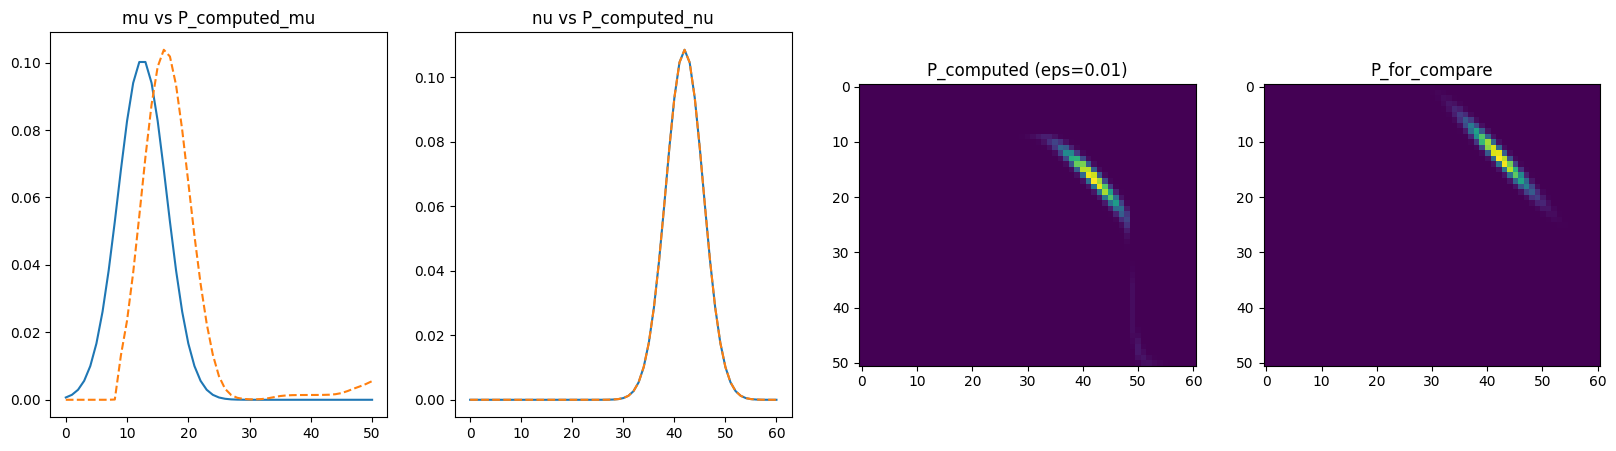

In [142]:
# to compare with
P_test, _, _ = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)

analyze_solutions(mu_1, nu_1, P_0_psi_sink, P_test, epsilon, C_1)

test on psi_1

In [143]:
epsilon = 0.1
u_0 = np.zeros_like(mu_1)
v_0 = np.zeros_like(nu_1)
P_1_psi_sink, u_1, v_1 = psi_sinkhorn(mu_1, nu_1, C_1, u_0, v_0, epsilon, psi_1_prime, alpha=0.03, max_iter=13)

n_iters: 1
n_iters: 2
n_iters: 3
n_iters: 4
n_iters: 5
n_iters: 6
n_iters: 7
n_iters: 8
n_iters: 9
n_iters: 10
n_iters: 11
n_iters: 12
n_iters: 13


n_iters: 24
Cost of P_computed: 0.005737023891065382
Cost of P_for_compare: 3.2850791721958967


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

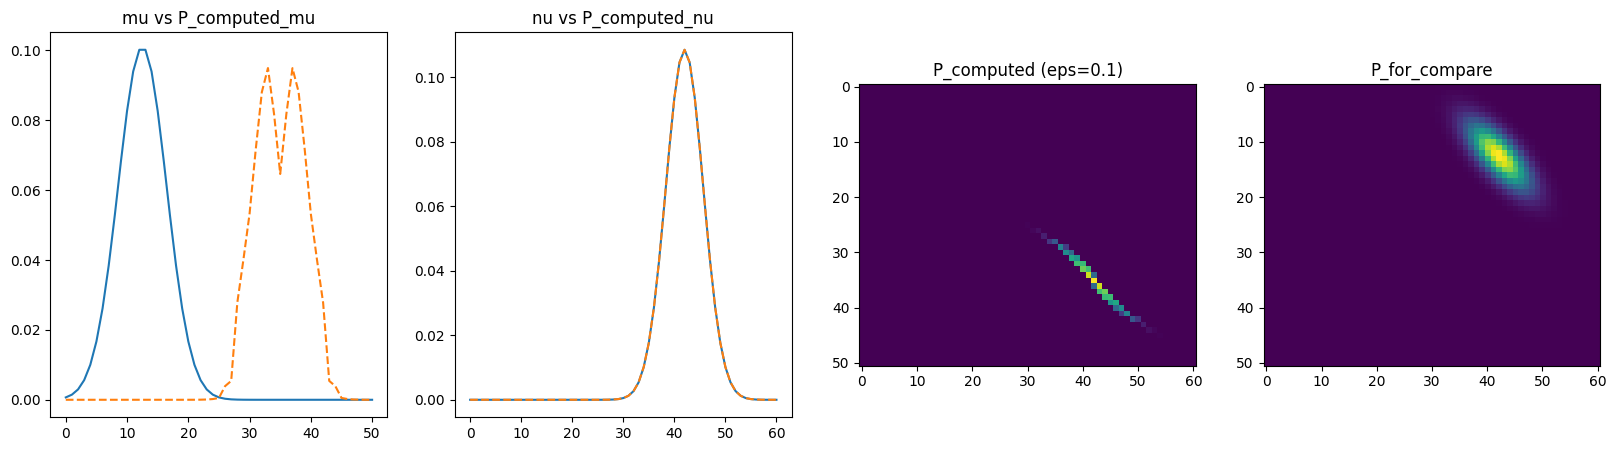

In [144]:
# to compare with
P_test, _, _ = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)

analyze_solutions(mu_1, nu_1, P_1_psi_sink, P_test, epsilon, C_1)

test on psi_2

In [145]:
epsilon = 0.1
u_0 = np.zeros_like(mu_1)
v_0 = np.zeros_like(nu_1)
P_2_psi_sink, u_2, v_2 = psi_sinkhorn(mu_1, nu_1, C_1, u_0, v_0, epsilon, psi_2_prime, alpha=0.03, max_iter=13)

n_iters: 1
n_iters: 2
n_iters: 3
n_iters: 4
n_iters: 5
n_iters: 6
n_iters: 7
n_iters: 8
n_iters: 9
n_iters: 10
n_iters: 11
n_iters: 12
n_iters: 13


n_iters: 24
Cost of P_computed: 3.2513580163190996
Cost of P_for_compare: 3.2850791721958967


array([<Axes: title={'center': 'mu vs P_computed_mu'}>,
       <Axes: title={'center': 'nu vs P_computed_nu'}>,
       <Axes: title={'center': 'P_computed (eps=0.1)'}>,
       <Axes: title={'center': 'P_for_compare'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

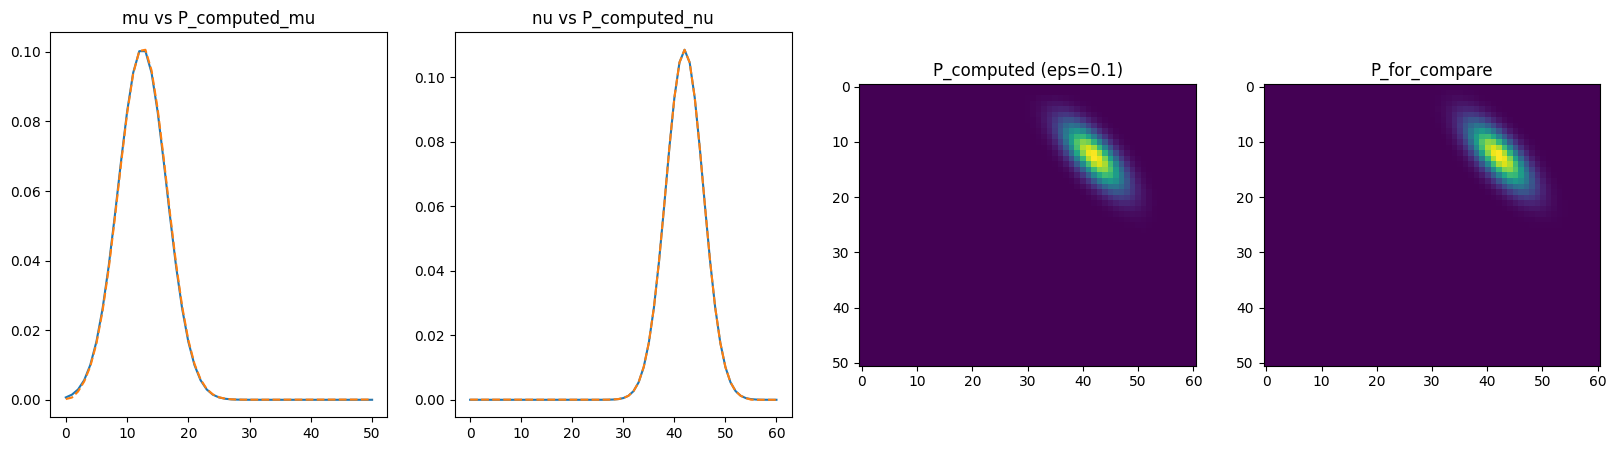

In [146]:
# to compare with
P_test, _, _ = sinkhorn(mu_1, nu_1, C_1, np.zeros_like(nu_1), eps=epsilon)

analyze_solutions(mu_1, nu_1, P_2_psi_sink, P_test, epsilon, C_1)

### Exercises:

You have free will of what you would like to experiment with, but possible options include:
- compute the potentials `u` and `v` with different methods (i.e., output of algorithms) and plot them to compare
- try to generate some more measures or costs to compare, of your choice
- you may also create some 2D examples, or just take a `mnist` dataset and try to solve OT for them using the implemented methods above
- (more advanced) for curious individuals, take a look at other optimization methods, e.g. with adam, automatic differentiation, etc.


In [ ]:
"""Free space to play around on your own"""